In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

# Check for GPU
print(f"TensorFlow Version: {tf.__version__}")
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT available")

d:\codes\ML\FYP\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow Version: 2.20.0
GPU is NOT available


In [2]:
# --- PATHS (As defined previously) ---
path_cases = '../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_19_india.csv'
path_vaccine = '../../RAW_DATA/Covid_19/covid_19_india/covid_vaccine_statewise.csv'
# Using all 3 mobility files for maximum data
path_mob_2020 = '../../RAW_DATA/Transportion/2020_IN_Region_Mobility_Report.csv'
path_mob_2021 = '../../RAW_DATA/Transportion/2021_IN_Region_Mobility_Report.csv'
path_mob_2022 = '../../RAW_DATA/Transportion/2022_IN_Region_Mobility_Report.csv'

# --- 1. LOAD & MERGE MOBILITY ---
try:
    df_m20 = pd.read_csv(path_mob_2020)
    df_m21 = pd.read_csv(path_mob_2021)
    df_m22 = pd.read_csv(path_mob_2022)
    mobility_full = pd.concat([df_m20, df_m21, df_m22])
    
    # Filter for INDIA National Level
    india_mob = mobility_full[(mobility_full['country_region_code'] == 'IN') & (mobility_full['sub_region_1'].isnull())].copy()
    india_mob['Date'] = pd.to_datetime(india_mob['date'])
    
    # Calculate Average Mobility & Apply Lag
    mob_cols = ['retail_and_recreation_percent_change_from_baseline', 
                'transit_stations_percent_change_from_baseline', 
                'workplaces_percent_change_from_baseline']
    
    # 7-Day Smoothing + 14-Day Shift (Lag)
    india_mob['Mobility_Avg'] = india_mob[mob_cols].mean(axis=1).rolling(7).mean().shift(14).fillna(0)
    
except Exception as e:
    print(f"Mobility Error: {e}")
    india_mob = pd.DataFrame(columns=['Date', 'Mobility_Avg'])

# --- 2. LOAD CASES & VACCINES ---
df_cases = pd.read_csv(path_cases)
df_cases['Date'] = pd.to_datetime(df_cases['Date'], format='%Y-%m-%d')
india_cases = df_cases.groupby('Date')[['Confirmed']].sum().reset_index()

# Calculate New Cases (Target)
india_cases['New_Cases'] = india_cases['Confirmed'].diff().fillna(0)
india_cases['New_Cases'] = india_cases['New_Cases'].clip(lower=0) # No negative cases

# --- 3. MERGE EVERYTHING ---
master_df = pd.merge(india_cases, india_mob[['Date', 'Mobility_Avg']], on='Date', how='left').fillna(0)

# Sort by date essential for LSTM
master_df = master_df.sort_values('Date').reset_index(drop=True)

print(f"Data Ready: {len(master_df)} days.")
print(master_df.tail())

Data Ready: 560 days.
          Date  Confirmed  New_Cases  Mobility_Avg
555 2021-08-07   31895385    38628.0    -20.190476
556 2021-08-08   31934455    39070.0    -20.142857
557 2021-08-09   31969954    35499.0    -19.714286
558 2021-08-10   31998158    28204.0    -19.714286
559 2021-08-11   32036511    38353.0    -18.238095


In [6]:
# --- CONFIGURATION ---
LOOK_BACK = 60   # How many past days the model sees to predict the next one
TEST_DAYS = 100  # Last 100 days for testing

# Select Features
# 1. Target: New Cases
# 2. Feature: Mobility (Lagged)
feature_cols = ['New_Cases', 'Mobility_Avg'] 

# --- SCALING (Crucial for Neural Networks) ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(master_df[feature_cols])

# --- CREATE SEQUENCES (Sliding Window) ---
def create_sequences(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        # Input: Past 'look_back' days (all features)
        X.append(dataset[i-look_back:i, :]) 
        # Output: The 'New_Cases' of the current day (Index 0 is New_Cases)
        y.append(dataset[i, 0]) 
    return np.array(X), np.array(y)

# Prepare Train/Test Split
train_size = len(scaled_data) - TEST_DAYS
train_data = scaled_data[:train_size]
test_data  = scaled_data[train_size - LOOK_BACK:] # Include overlap for continuity

X_train, y_train = create_sequences(train_data, LOOK_BACK)
X_test, y_test   = create_sequences(test_data, LOOK_BACK)

# Reshape input to be [Samples, Time Steps, Features]
print(f"X_train shape: {X_train.shape}") # (Samples, 60, 2)
print(f"X_test shape:  {X_test.shape}")

X_train shape: (400, 60, 2)
X_test shape:  (100, 60, 2)


Training Model... (This may take a minute)
Epoch 1/50


d:\codes\ML\FYP\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0029 - val_loss: 0.0776
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0010 - val_loss: 0.0523
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9418e-04 - val_loss: 0.0592
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.1970e-04 - val_loss: 0.0448
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.3162e-04 - val_loss: 0.0557
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.2784e-04 - val_loss: 0.0421
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.6557e-04 - val_loss: 0.0413
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.8178e-04 - val_loss: 0.0401
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.9371e-04 - val_loss: 0.0366
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.6418e-04 - val_loss: 0.0412
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.3901e-04 - val_loss: 0.0343
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━

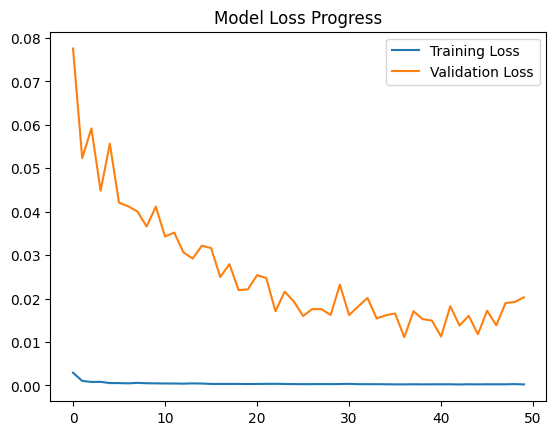

In [7]:
# --- BUILD MODEL ---
model = Sequential()

# Layer 1: LSTM with 50 units
# return_sequences=True because we have another LSTM layer coming
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # Prevent overfitting

# Layer 2: LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Layer 3: Dense (Output)
model.add(Dense(units=1)) # Prediction of New_Cases

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

# --- TRAIN ---
print("Training Model... (This may take a minute)")
history = model.fit(
    X_train, y_train, 
    epochs=50,           # Iterations
    batch_size=32,       # How many samples per update
    validation_split=0.1, # Use 10% of training data to validate
    verbose=1
)

# Plot Loss Curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


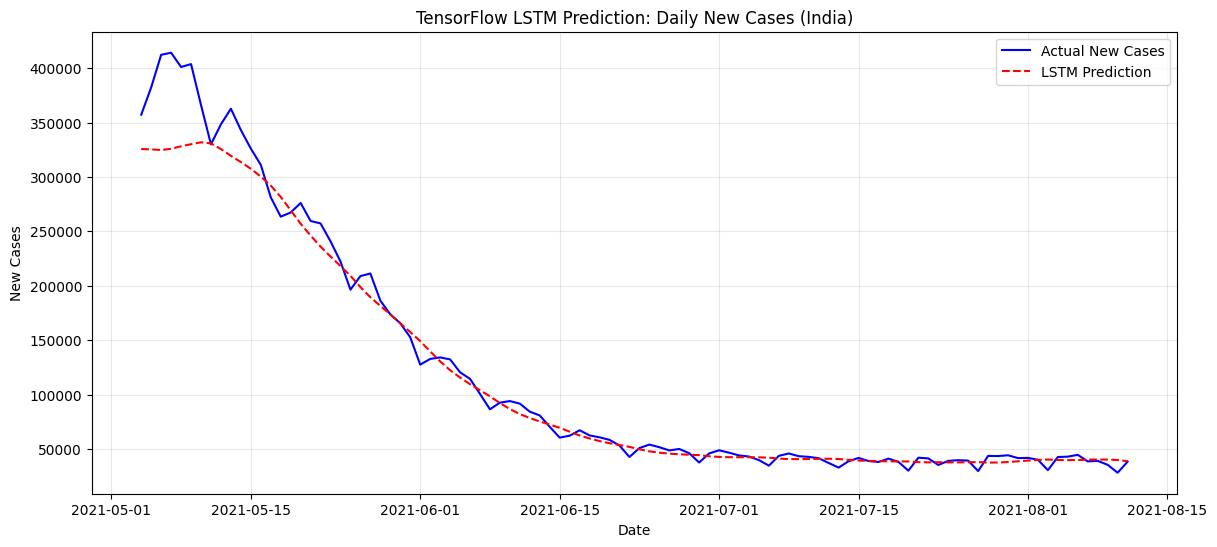

R2 Score: 0.9702


In [8]:
# --- PREDICT ---
predictions_scaled = model.predict(X_test)

# --- INVERSE SCALING ---
# We scaled 2 columns, but predicted only 1. We need to trick the scaler to inverse transform.
# Create a dummy array matching the original shape (Samples, 2)
dummy_array = np.zeros((len(predictions_scaled), 2))
dummy_array[:, 0] = predictions_scaled.flatten() # Fill 1st column with our predictions
inverse_predictions = scaler.inverse_transform(dummy_array)[:, 0] # Get back real numbers

# Get Actual Values (from y_test)
dummy_actual = np.zeros((len(y_test), 2))
dummy_actual[:, 0] = y_test
inverse_actual = scaler.inverse_transform(dummy_actual)[:, 0]

# --- PLOTTING ---
plt.figure(figsize=(14, 6))

# Create Date Index for Plotting
test_dates = master_df['Date'].iloc[-len(inverse_actual):]

plt.plot(test_dates, inverse_actual, color='blue', label='Actual New Cases')
plt.plot(test_dates, inverse_predictions, color='red', linestyle='--', label='LSTM Prediction')

plt.title('TensorFlow LSTM Prediction: Daily New Cases (India)')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Accuracy Score
print(f"R2 Score: {r2_score(inverse_actual, inverse_predictions):.4f}")